# A Short Introduction to Time Series Forecasting

**Forecasting** is where we try to predict an variables future value. Businesses forecast product demand, governments forecast economic and population growth, meteorologists forecast the weather. In this guide you'll learn to:

- engineer features to model the major time series components (trends, seasons, and cycles),
- visualize time series with many kinds of time series plots,
- create forecasting hybrids that combine the strengths of complementary models, and
- adapt machine learning methods to a variety of forecasting tasks.

Written with the help of [this kaggle tutorial](https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series) and these [videos](https://www.youtube.com/watch?v=9QtL7m3YS9I), and some figures taken from [this blog](https://medium.com/analytics-vidhya/time-series-forecasting-c73dec0b7533).

> “Forecasting is the art of saying what will happen, and then explaining why it didn’t!”
>

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
# OS
from pathlib import Path

# Styling
color_pal = sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-colorblind') 

# Warnings control
import warnings 
warnings.filterwarnings('ignore')



In [73]:
data_path = Path('price/INTC.csv') # Update your path here

In [74]:
df = pd.read_csv(data_path, header=0)

### A quick look at the dataframe

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Open       1258 non-null   float64
 2   High       1258 non-null   float64
 3   Low        1258 non-null   float64
 4   Close      1258 non-null   float64
 5   Adj Close  1258 non-null   float64
 6   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [76]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,25.030001,25.059999,24.270000,24.420000,20.711935,40688000
1,2012-09-05,24.400000,24.780001,24.190001,24.389999,20.686487,38595800
2,2012-09-06,24.469999,25.100000,24.459999,25.100000,21.288677,40187600
3,2012-09-07,24.129999,24.700001,24.010000,24.190001,20.516853,86282100
4,2012-09-10,23.950001,24.600000,23.170000,23.260000,19.728077,80584600


### Data Cleaning

Steps undertaken:
- set index
- typecast

In [77]:
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

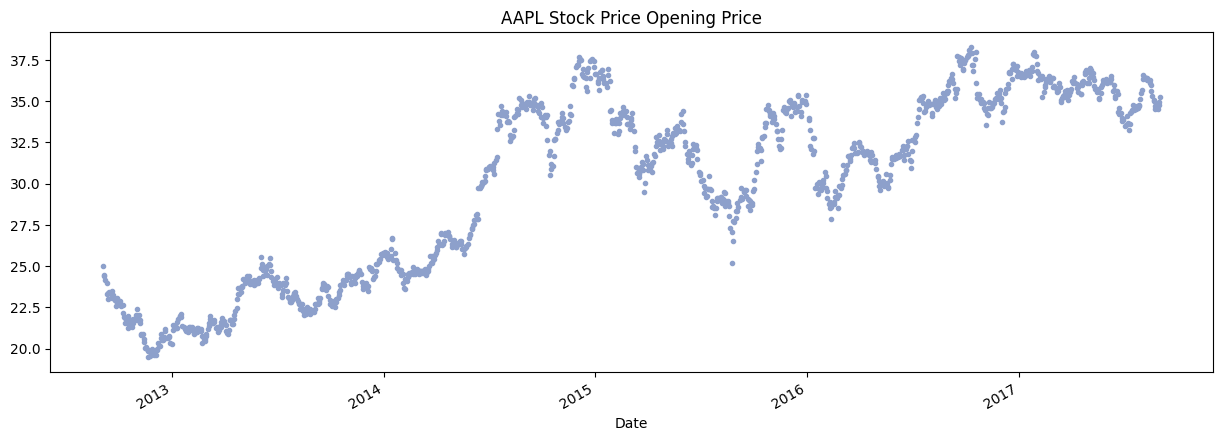

In [78]:
df["Open"].plot(title='AAPL Stock Price Opening Price',
        style='.',
        figsize=(15,5),
        use_index=True,
        color=color_pal[2])
plt.show()

<Axes: ylabel='Frequency'>

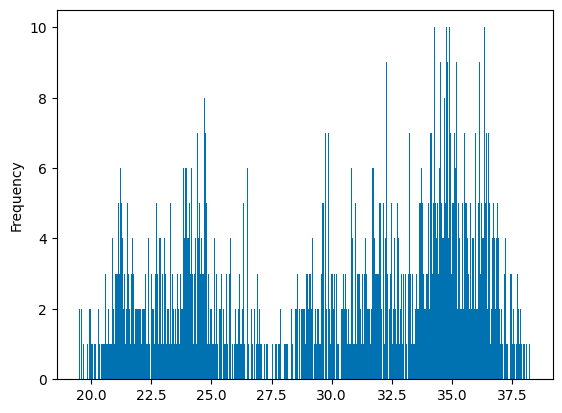

In [79]:
df['Open'].plot(kind='hist', bins=500) # Opening prices are not normal

In [80]:
df['Pct Change'] = df['Close'].pct_change() * 100

In [81]:
df.describe()


,Open,High,Low,Close,Adj Close,Volume,Pct Change
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1257.000000
mean,29.985676,30.247194,29.738593,30.005238,27.957586,3.103016e+07,0.038205
std,5.370144,5.400717,5.331414,5.374578,6.033379,1.618260e+07,1.368211
min,19.520000,19.549999,19.230000,19.360001,16.589478,5.893800e+06,-9.102021
25%,24.542500,24.742500,24.400000,24.542500,21.852218,2.092898e+07,-0.684556
50%,31.430000,31.760000,31.200001,31.500000,29.652850,2.708505e+07,0.062076
75%,34.750000,34.959999,34.497501,34.750000,33.353392,3.539780e+07,0.751880
max,38.250000,38.450001,37.900002,38.099998,37.153412,1.437604e+08,9.271533


In [82]:
df['Pct Change']


Date
2012-09-04         NaN
2012-09-05   -0.122854
2012-09-06    2.911033
2012-09-07   -3.625494
2012-09-10   -3.844568
                ...   
2017-08-28   -0.057675
2017-08-29    0.230874
2017-08-30    0.460694
2017-08-31    0.515910
2017-09-01    0.057029
Name: Pct Change, Length: 1258, dtype: float64

 # Percent change is relatively more normally distributed

<Axes: ylabel='Frequency'>

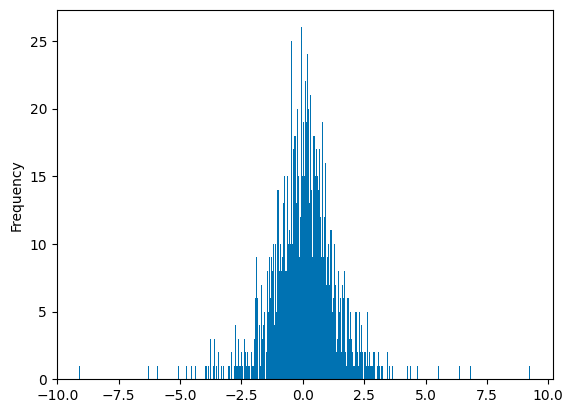

In [83]:
df['Pct Change'].plot(kind='hist', bins=500)

## Train Test Split

- Important to prevent our model from horribly overfitting

We set the train set before 2016, while 2016 to 2017 data is the test set.

In [84]:
train = df.loc[df.index < '01-01-2016']
test = df.loc[df.index >= '01-01-2016']

In [85]:
train

,Open,High,Low,Close,Adj Close,Volume,Pct Change
Date,,,,,,,
2012-09-04,25.030001,25.059999,24.270000,24.420000,20.711935,40688000,NaN
2012-09-05,24.400000,24.780001,24.190001,24.389999,20.686487,38595800,-0.122854
2012-09-06,24.469999,25.100000,24.459999,25.100000,21.288677,40187600,2.911033
2012-09-07,24.129999,24.700001,24.010000,24.190001,20.516853,86282100,-3.625494
2012-09-10,23.950001,24.600000,23.170000,23.260000,19.728077,80584600,-3.844568
...,...,...,...,...,...,...,...
2015-12-24,35.070000,35.259998,34.959999,34.980000,33.125854,5893800,-0.057143
2015-12-28,34.950001,35.000000,34.570000,34.930000,33.078503,9449400,-0.142939
2015-12-29,35.009998,35.590000,35.009998,35.439999,33.561470,14188600,1.460060


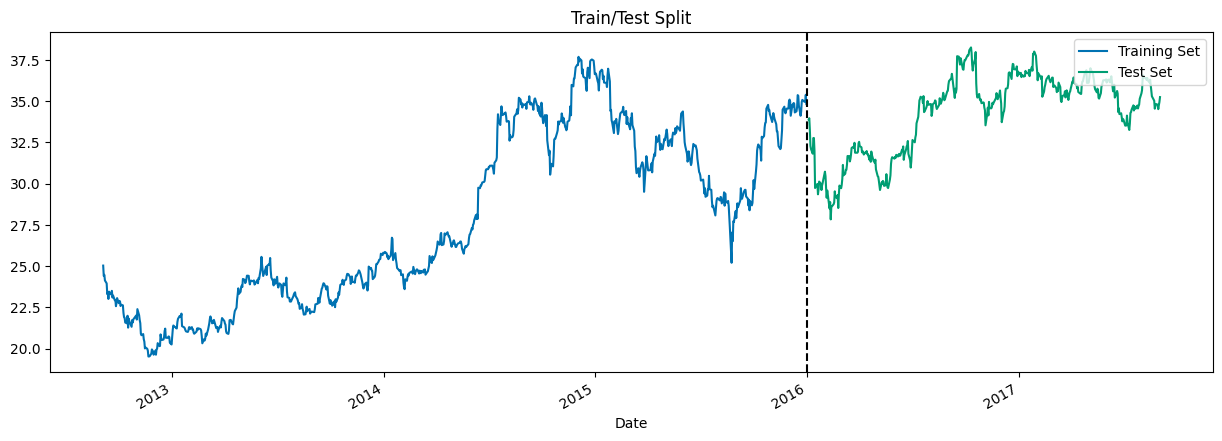

In [86]:
fig, ax = plt.subplots(figsize=(15,5))

train['Open'].plot(ax=ax, label='Train', title='Train/Test Split')
test['Open'].plot(ax=ax, label='Test')
ax.axvline('01-01-2016', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

### Using Time Series Cross Validation

In [87]:
from sklearn.model_selection import TimeSeriesSplit

In [88]:
tss = TimeSeriesSplit(n_splits = 5)
df = df.sort_index()

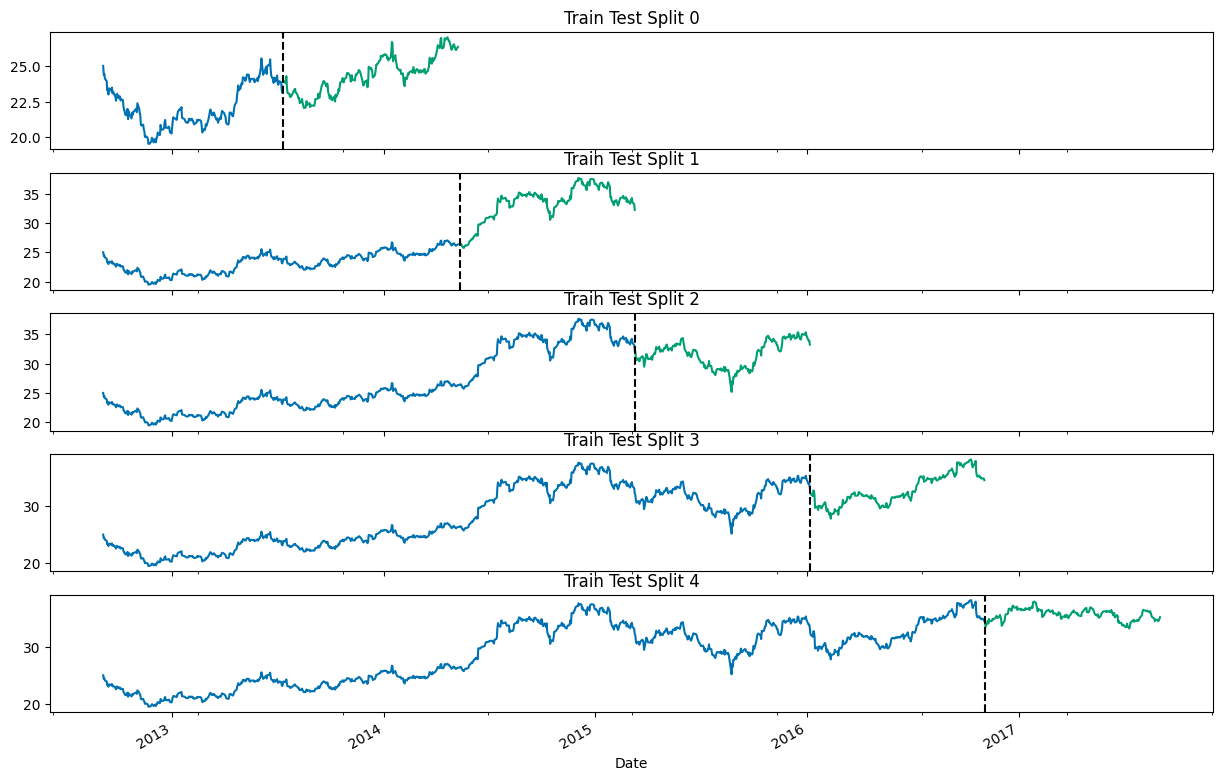

In [89]:
fig, axs = plt.subplots(5, 1, figsize=(15,10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Open'].plot(ax = axs[fold],
                          label='Training Set',
                          title = f'Train Test Split {fold}')
    test['Open'].plot(ax = axs[fold],
                          label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

## Feature Creation

In [90]:
def create_features(df):
    """
    Create time series features given df with datetime index
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

In [91]:
df = create_features(df)

### Lag Features

#### What was the target x days in the past

In [110]:
def add_lags(df):
    target_map = df['Open'].to_dict()
    pct_map = df['Pct Change'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map) 
    df['lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['lag5'] = (df.index - pd.Timedelta('5 days')).map(target_map)
    df['Pct_lag_1'] = (df.index - pd.Timedelta('1 days')).map(pct_map)
    return df

In [111]:
df = add_lags(df)

In [112]:
df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,Pct Change,dayofweek,quarter,month,year,lag1,lag2,lag3,lag5,Pct_lag_1,prediction
Date,,,,,,,,,,,,,,,,,
2017-08-28,34.779999,34.799999,34.590000,34.650002,34.650002,20712900,-0.057675,0,3,8,2017,NaN,NaN,34.820000,34.540001,NaN,32.528893
2017-08-29,34.509998,34.750000,34.459999,34.730000,34.730000,15843700,0.230874,1,3,8,2017,34.779999,NaN,NaN,34.700001,-0.057675,34.610825
2017-08-30,34.750000,34.959999,34.630001,34.889999,34.889999,18565000,0.460694,2,3,8,2017,34.509998,34.779999,NaN,34.820000,0.230874,34.584976
2017-08-31,34.939999,35.180000,34.869999,35.070000,35.070000,16366800,0.515910,3,3,8,2017,34.750000,34.509998,34.779999,NaN,0.460694,34.610825
2017-09-01,35.240002,35.389999,35.070000,35.090000,35.090000,12818900,0.057029,4,3,9,2017,34.939999,34.750000,34.509998,NaN,0.515910,34.724583


In [115]:

# 输出 'prediction' 列中带有 NaN 的行
nan_prediction_rows = df[df['prediction'].isna()]
nan_prediction_rows


,Open,High,Low,Close,Adj Close,Volume,Pct Change,dayofweek,quarter,month,year,lag1,lag2,lag3,lag5,Pct_lag_1,prediction
Date,,,,,,,,,,,,,,,,,
2012-09-04,25.030001,25.059999,24.270000,24.420000,20.711935,40688000,NaN,1,3,9,2012,NaN,NaN,NaN,NaN,NaN,NaN
2012-09-05,24.400000,24.780001,24.190001,24.389999,20.686487,38595800,-0.122854,2,3,9,2012,25.030001,NaN,NaN,NaN,NaN,NaN
2012-09-06,24.469999,25.100000,24.459999,25.100000,21.288677,40187600,2.911033,3,3,9,2012,24.400000,25.030001,NaN,NaN,-0.122854,NaN
2012-09-07,24.129999,24.700001,24.010000,24.190001,20.516853,86282100,-3.625494,4,3,9,2012,24.469999,24.400000,25.030001,NaN,2.911033,NaN
2012-09-10,23.950001,24.600000,23.170000,23.260000,19.728077,80584600,-3.844568,0,3,9,2012,NaN,NaN,24.129999,24.400000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-10-27,35.099998,35.230000,34.750000,34.810001,33.796520,14634700,-0.314997,3,4,10,2016,35.040001,35.139999,35.430000,NaN,-0.512821,NaN
2016-10-28,34.869999,35.169998,34.709999,34.740002,33.728561,22296400,-0.201089,4,4,10,2016,35.099998,35.040001,35.139999,NaN,-0.314997,NaN
2016-10-31,34.919998,35.080002,34.840000,34.869999,33.854767,19188600,0.374200,0,4,10,2016,NaN,NaN,34.869999,35.040001,NaN,NaN


### Visalising Feature / Target Relationship

In [95]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Pct Change',
       'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3', 'lag5',
       'Pct_lag_1'],
      dtype='object')

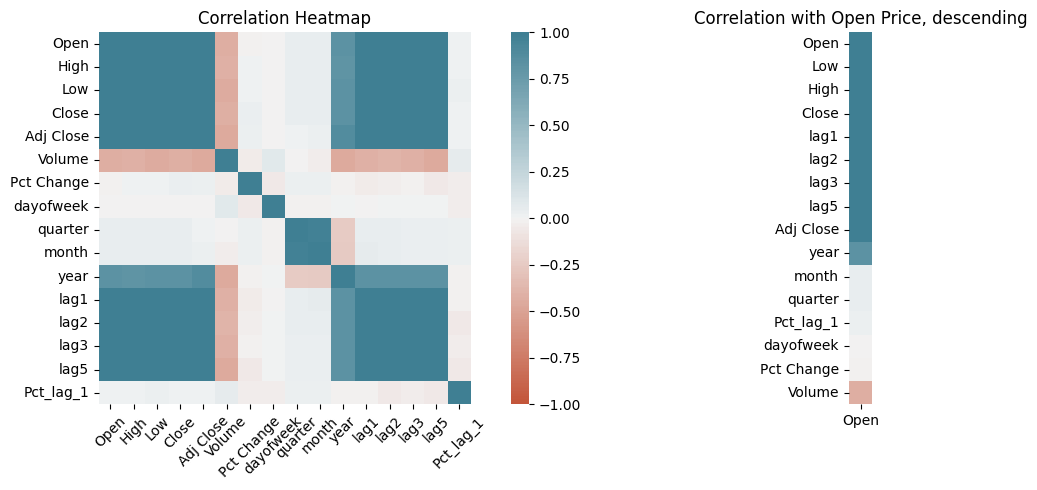

In [96]:
corr = df.corr() 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=-0.5, top=0.9, left=0.1)
ax1 = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), 
    square=True,
    ax = ax1
)
ax1.set_xticklabels(
    ax1.get_xticklabels(),
    rotation=45,
    # horizontalalignment='right'
)
ax1.set_title('Correlation Heatmap')

# plotting correlation with target
corr_target = df.corr()[['Open']].sort_values(by=['Open'],ascending=False)
ax2 = sns.heatmap(corr_target,
                  vmin=-1, vmax=1, 
                  cmap=sns.diverging_palette(20, 220, n=200),
                  square=True,
                  cbar=False,
                  ax=ax2)
ax2.set_title('Correlation with Open Price, descending');
plt.tight_layout()

We can see that the most strongly correlated variable is high, low, close (which we shouldn't know), but also the lag features and the year

## Model Creation

In [97]:
import xgboost as xgb

tss = TimeSeriesSplit(n_splits=5)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['year', 'lag1','lag2', 'month', 'dayofweek', 'quarter', 'Volume']
    TARGET = 'Open'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=500,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mse(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:21.51236	validation_1-rmse:23.69898


[100]	validation_0-rmse:8.00170	validation_1-rmse:9.88480
[200]	validation_0-rmse:3.02871	validation_1-rmse:4.93577
[300]	validation_0-rmse:1.21183	validation_1-rmse:3.13083
[400]	validation_0-rmse:0.60127	validation_1-rmse:2.53244
[499]	validation_0-rmse:0.41723	validation_1-rmse:2.33448
[0]	validation_0-rmse:22.61022	validation_1-rmse:32.71255
[100]	validation_0-rmse:8.38119	validation_1-rmse:17.59654
[200]	validation_0-rmse:3.16928	validation_1-rmse:11.57986
[300]	validation_0-rmse:1.29314	validation_1-rmse:9.21352
[400]	validation_0-rmse:0.66449	validation_1-rmse:8.21522
[499]	validation_0-rmse:0.47313	validation_1-rmse:7.73387
[0]	validation_0-rmse:26.35083	validation_1-rmse:30.87881
[100]	validation_0-rmse:9.84318	validation_1-rmse:10.76764
[200]	validation_0-rmse:3.80022	validation_1-rmse:3.09546
[300]	validation_0-rmse:1.65668	validation_1-rmse:1.80635
[320]	validation_0-rmse:1.44965	validation_1-rmse:1.92270
[0]	validation_0-rmse:27.54653	validation_1-rmse:32.17428
[100]	valid

In [98]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3.0535
Fold scores:[2.334479573747993, 7.733865677174162, 1.7087462073939903, 1.6578651038859378, 1.8327036428406562]


### Feature Importances

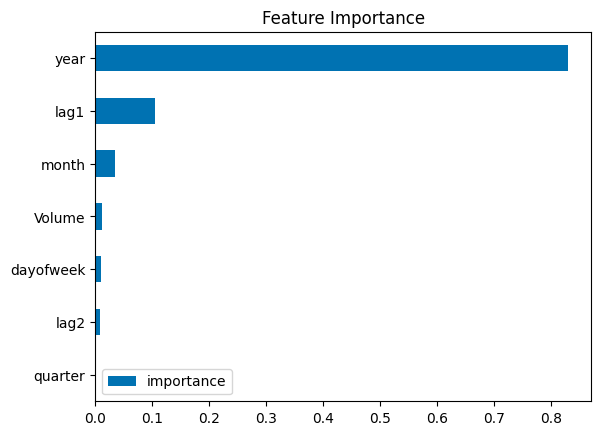

In [99]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [100]:
# predict on test data
test['prediction'] = reg.predict(X_test)

In [101]:
# merging with the df and the test dataset
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

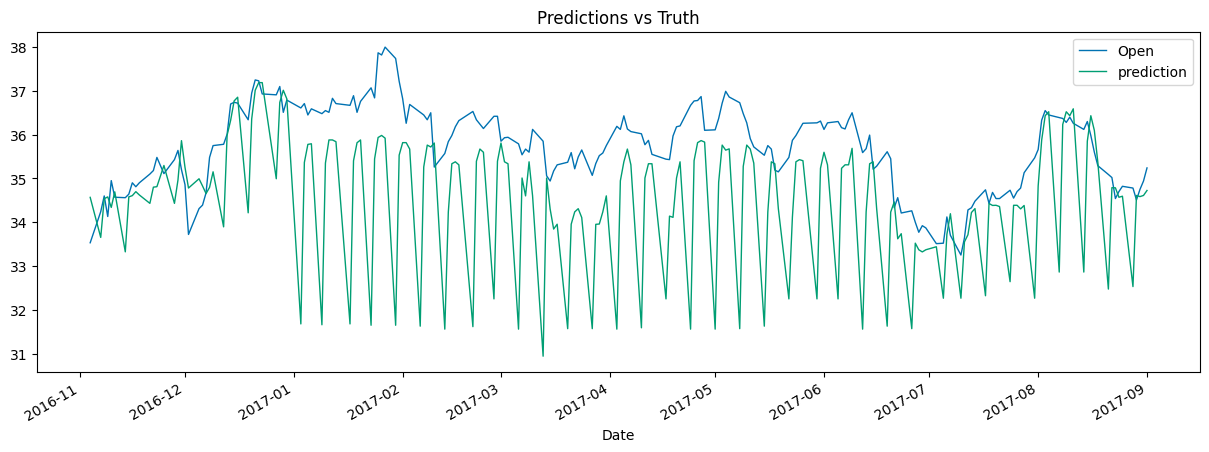

In [102]:
df.loc[(df.index >'11-03-2016')][['Open', 'prediction']] \
    .plot(figsize=(15,5), ms=1, lw=1, title='Predictions vs Truth');